In [1]:
!pip install keras_core
!pip install keras_nlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Succe

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.16.2
KerasNLP version: 0.14.0


# Fake and Real News Classification Problem

## Problem Description:

<span style="font-size:1.1em;">  The goal is to be able to classify wether or not a particular new item is real or fake.</span>


<span style="font-size:1.1em;"> Lets first load the data and explore it </span>


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/fake_news/

/content/drive/My Drive/fake_news


In [5]:
real_news_data = pd.read_csv("True.csv")[['text']]
fake_news_data = pd.read_csv("Fake.csv")[['text']]



print('real_news_data Set Shape = {}'.format(real_news_data.shape))
print('fake_news_data Set Shape = {}'.format(fake_news_data.shape))

real_news_data Set Shape = (21417, 1)
fake_news_data Set Shape = (23481, 1)


In [6]:
real_news_data['target'] = 1
fake_news_data['target'] = 0

In [7]:

real_news_data.head()


,text,target
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [8]:
fake_news_data.head()

,text,target
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [9]:
df = pd.concat([fake_news_data,real_news_data]).sample(frac=1).reset_index(drop=True)

In [10]:
df

,text,target
0,Donald Trump has often invoked the U.S. milita...,0
1,SINGAPORE (Reuters) - Donald Trump’s “isolatio...,1
2,21st Century Wire asks HAVE YOUR SHOUT: Apple...,0
3,WASHINGTON (Reuters) - Billionaire philanthrop...,1
4,Hillary Clinton took a swing back at Donald Tr...,0
...,...,...
44893,There s no need for Barack Obama and Valerie J...,0
44894,MOSCOW (Reuters) - Former Russian economy mini...,1
44895,Donald Trump hasn t even been president for a ...,0
44896,"AUSTIN, Texas (Reuters) - The Republican-contr...",1


Text(0.5, 1.0, 'Target Dist.')

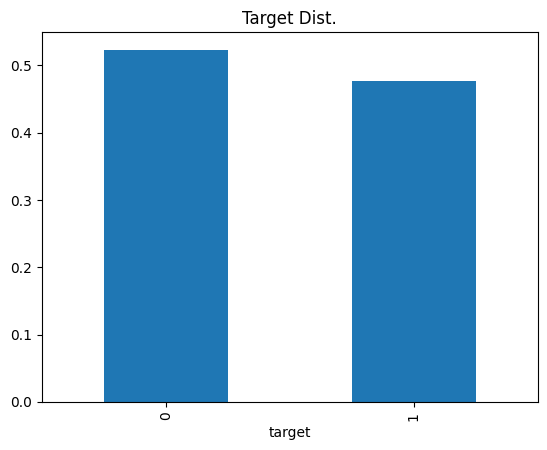

In [11]:
df.target.value_counts(normalize=True).plot(kind='bar')
plt.title('Target Dist.')

Drop duplicates

In [12]:
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

6251
0


Check for NaN

In [13]:
df.isna().sum()

text      0
target    0
dtype: int64

In [17]:
df["length"] = df["text"].apply(lambda x : len(x))


<ipython-input-17-5a1bbd199391>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length"] = df["text"].apply(lambda x : len(x))


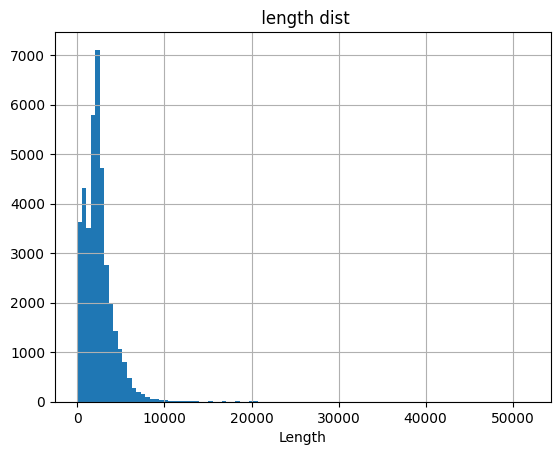

Stat
count    38647.000000
mean      2455.824540
std       1936.624786
min          1.000000
25%       1318.000000
50%       2227.000000
75%       3096.000000
max      51794.000000
Name: length, dtype: float64


In [18]:
df["length"].hist(bins=100)
plt.xlabel("Length")
plt.title(" length dist")
plt.show()
print("Stat")
print(df["length"].describe())

In [19]:
X = df['text']
y = df['target']

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((30917,), (7730,), (30917,), (7730,))

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.regularizers import l2

In [26]:

# Text preprocessing
max_words = 10000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build LSTM model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = History()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

model.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_split=0.2, callbacks=[history, early_stopping])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8421 - loss: 1.1913 - val_accuracy: 0.9777 - val_loss: 0.1565
Epoch 2/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 249s 972ms/step - accuracy: 0.9661 - loss: 0.1912 - val_accuracy: 0.9730 - val_loss: 0.1678
Epoch 3/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 202s 975ms/step - accuracy: 0.9649 - loss: 0.1914 - val_accuracy: 0.9774 - val_loss: 0.1415
Epoch 4/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 187s 967ms/step - accuracy: 0.9793 - loss: 0.1401 - val_accuracy: 0.9798 - val_loss: 0.1276
Epoch 5/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 201s 957ms/step - accuracy: 0.9811 - loss: 0.1302 - val_accuracy: 0.9791 - val_loss: 0.1237
Restoring model weights from the end of the best epoch: 5.


In [27]:
# Predict
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")



242/242 ━━━━━━━━━━━━━━━━━━━━ 59s 242ms/step


NameError: name 'precision_score' is not defined

Accuracy: 0.9767141009055628
Precision: 0.9679442508710802
Recall: 0.9900213827512473
F1 Score: 0.9788583509513742


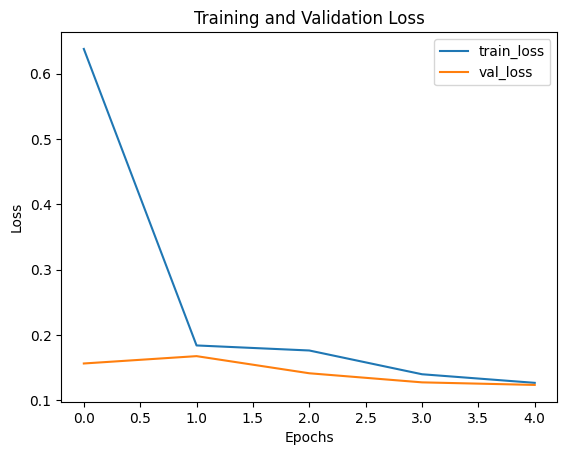

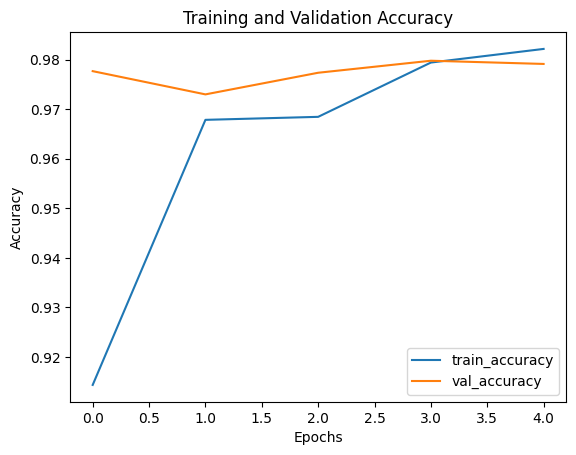

In [29]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
# Save the weights
model.save_weights('./my_checkpoint.weights.h5')



In [ ]:
# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('./my_checkpoint.weights.h5')

## Last entry

<span style="font-size:1.1em;"> We see that we have 7613 training examples and 3263 test examples.
The training data containes an id column which provides a numerical id number for each twet text. a text column with the actual test and a target column which has the training label 1 means the tweet is actually referring to a real disaster, 0 means its not.
There are also keywod and location columns which seems to not contain any useful data.
The test dataframe has the same structue except it doesnt have the training label ("target")column.</span>

<span style="font-size:1.1em;"> We also see that all the tweets are in english</span>

<span style="font-size:1.1em;"> Lets looks at some statistics on teh length of the tweets</span>


## Model Architecture


<span style="font-size:1.1em;">I have chosen to use the BERT model architecture. This model is based on transformer encoders and is well suited for NLP tasks such as sentiment classification which is similar to the task we have here. One advantage is that we have available pre-trained model which we can fine tune with our data allowing us to use a more powerfull and large model with our relatively small computational resource.</span>

<span style="font-size:1.1em;">The image below shows a rough diagram of the BERT model architecture  </span>

![alt text](https://github.com/yepe4401/NLP_disaster_tweets/blob/main/BERT.jpeg?raw=1)

 <span style="font-size:1.1em;">In the input processing layer the input sequence is first broken up into tokens. The tokens are then geven token embeddings which are continuous vectors of length 768. The first token embedding is special and called [CLS] token. This token is what will be finally used for classification. The input layers also generate segmenta and position embeddings which help with longer text sequences to identify the location of sentences within a larger text. This is probably less important for our tweet classifcation task.

 <span style="font-size:1.1em;"> The embedding vectors are then propagated through a seires of transformer encoders. Each transformer encoder layer uses Multi-head self attention which allows it to consider all the tokens in the sequence at the same time. Feedforward and residual connections are provided to stabilize training and avoid exploding gradients or vanshing gradients. </span>

 <span style="font-size:1.1em;"> As the vectors propagate from one encoder layer to the next increasingly complex information can be extracted from them. At the outpout layer the [CLS] token which has been updated at each layer can be used in a fully connected layer of size 768 x (number of classes to classify the output. In our case thats 1536 + 2 bias parameters. The code for loading and trainign the BERT model is shown below. We are using the DistilledBERT which is slightly lighter model that maintains most ofthe same perforamnce</span>


In [23]:

# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=500,
                                                                   name="custom_preprocessor"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()


classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics= ["accuracy"]
    )


# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=64,
                         epochs=2,
                         validation_data=(X_test, y_test)
                        )


Preprocessor: "custom_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-23-b62b236a6d8a>", line 26, in <cell line: 26>

  File "/usr/local/lib/python3.10/dist-packages/keras_nlp/src/utils/pipeline_model.py", line 193, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 17183467296 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  766.39MiB
              constant allocation:         0B
        maybe_live_out allocation:  766.24MiB
     preallocated temp allocation:   16.00GiB
  preallocated temp fragmentation:  124.34MiB (0.76%)
                 total allocation:   16.75GiB
              total fragmentation:  124.40MiB (0.73%)
Peak buffers:
	Buffer 1:
		Size: 732.42MiB
		XLA Label: fusion
		Shape: f32[768,500,500]
		==========================

	Buffer 2:
		Size: 732.42MiB
		Operator: op_type="BatchMatMulV2" op_name="gradient_tape/distil_bert_classifier_2_1/distil_bert_backbone_1/transformer_layer_5_1/self_attention_layer_1/MatMul_1/MatMul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[768,500,500]
		==========================

	Buffer 3:
		Size: 732.42MiB
		Operator: op_type="Transpose" op_name="distil_bert_classifier_2_1/distil_bert_backbone_1/transformer_layer_5_1/self_attention_layer_1/transpose_2" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[768,500,500]
		==========================

	Buffer 4:
		Size: 732.42MiB
		Operator: op_type="Transpose" op_name="distil_bert_classifier_2_1/distil_bert_backbone_1/transformer_layer_4_1/self_attention_layer_1/transpose_2" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[768,500,500]
		==========================

	Buffer 5:
		Size: 732.42MiB
		Operator: op_type="Transpose" op_name="distil_bert_classifier_2_1/distil_bert_backbone_1/transformer_layer_3_1/self_attention_layer_1/transpose_2" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[768,500,500]
		==========================

	Buffer 6:
		Size: 732.42MiB
		Operator: op_type="Transpose" op_name="distil_bert_classifier_2_1/distil_bert_backbone_1/transformer_layer_2_1/self_attention_layer_1/transpose_2" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[768,500,500]
		==========================

	Buffer 7:
		Size: 732.42MiB
		Operator: op_type="Transpose" op_name="distil_bert_classifier_2_1/distil_bert_backbone_1/transformer_layer_1_1/self_attention_layer_1/transpose_2" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[768,500,500]
		==========================

	Buffer 8:
		Size: 732.42MiB
		Operator: op_type="Transpose" op_name="distil_bert_classifier_2_1/distil_bert_backbone_1/transformer_layer_0_1/self_attention_layer_1/transpose_2" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[768,500,500]
		==========================

	Buffer 9:
		Size: 732.42MiB
		XLA Label: fusion
		Shape: f32[768,500,500]
		==========================

	Buffer 10:
		Size: 732.42MiB
		XLA Label: fusion
		Shape: f32[768,500,500]
		==========================

	Buffer 11:
		Size: 732.42MiB
		XLA Label: fusion
		Shape: f32[768,500,500]
		==========================

	Buffer 12:
		Size: 732.42MiB
		XLA Label: fusion
		Shape: f32[768,500,500]
		==========================

	Buffer 13:
		Size: 732.42MiB
		XLA Label: fusion
		Shape: f32[768,500,500]
		==========================

	Buffer 14:
		Size: 375.00MiB
		Operator: op_type="BatchMatMulV2" op_name="distil_bert_classifier_2_1/distil_bert_backbone_1/transformer_layer_4_1/feedforward_intermediate_dense_1/MatMul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32000,3072]
		==========================

	Buffer 15:
		Size: 375.00MiB
		Operator: op_type="BatchMatMulV2" op_name="distil_bert_classifier_2_1/distil_bert_backbone_1/transformer_layer_3_1/feedforward_intermediate_dense_1/MatMul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32000,3072]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_49263]

 <span style="font-size:1.1em;"> We see the performance is not that great. Lets try to increase the sequence length from 120 to 160.</span>

In [ ]:

# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="custom_preprocessor"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()


classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics= ["accuracy"]
    )


# Fit
history = classifier.fit(x=df_train["text"],
                         y=df_train["target"],
                         batch_size=64,
                         epochs=2,
                         validation_data=(X_val, y_val)
                        )



Preprocessor: "custom_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.5632 - loss: 0.7465 - val_accuracy: 0.5653 - val_loss: 0.6869
Epoch 2/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 102s 857ms/step - accuracy: 0.5975 - loss: 0.6849 - val_accuracy: 0.5653 - val_loss: 0.6858


 <span style="font-size:1.1em;"> Thats better. Lets see if we can improve performance more by tuning the learning rate. A shorter learning rate may be better</span>

In [ ]:

# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="custom_preprocessor"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()


classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics= ["accuracy"]
    )


# Fit
history = classifier.fit(x=df_train["text"],
                         y=df_train["target"],
                         batch_size=64,
                         epochs=2,
                         validation_data=(X_val, y_val)
                        )


Preprocessor: "custom_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.7055 - loss: 0.5794 - val_accuracy: 0.8582 - val_loss: 0.3536
Epoch 2/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.8444 - loss: 0.3803 - val_accuracy: 0.8726 - val_loss: 0.3742


 <span style="font-size:1.1em;"> This looks pretty good lets now predict on the test set</span>

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step


In [ ]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.475942
std,3146.427221,0.499497
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [ ]:
sample_submission.to_csv("submission.csv", index=False)

# Conclusion

 <span style="font-size:1.1em;">This problem was one similar to sentiment classification in NLP. Therefore using a pre-trained NLP using the transformer architecture was a good choice. We saw that limiting the pre-processing to focus on text length of 160 charatcers which is close to but not below the upp bound of the lengths of the tweets helped improve the accuracy. Also using a slower learning rate in the ADAM weight adaptation proved more beneficial than the deault.</span>